In [1]:
import numpy as np
import matplotlib.pyplot as plt
from epymorph.attribute import NamePattern
from epymorph.kit import *

from epymorph.simulation import Context
from epymorph.adrio import acs5, us_tiger
from epymorph.forecasting.dynamic_params import GaussianPrior, OrnsteinUhlenbeck,ExponentialTransform
from epymorph.forecasting.pipeline import (ParticleFilterSimulator,
EnsembleKalmanFilterSimulator,
Observations,
ModelLink,
PipelineConfig,
UnknownParam,
munge_pipeline_output)

from epymorph.forecasting.likelihood import Poisson

In [2]:
from typing_extensions import override
from epymorph.initializer import _POPULATION_ATTR
from epymorph.initializer import *


class RandomLocationsAndRandomSeed(SeededInfection):
    """
    Seed an random number of infected in a number of randomly selected locations.

    Requires "population" as a data attribute.

    Parameters
    ----------
    num_locations :
        The number of locations to choose.
    seed_max :
        The maximum number of individuals to infect.
    initial_compartment :
        Which compartment (by index or name) is "not infected", where most individuals
        start out.
    infection_compartment :
        Which compartment (by index or name) will be seeded as the initial infection.
    """

    requirements = (_POPULATION_ATTR,)

    num_locations: int
    """The number of locations to choose (randomly)."""
    seed_max: int
    """The maximum number of individuals to infect, drawn uniformly on [0,seed_max]."""

    def __init__(
        self,
        num_locations: int,
        seed_max: int,
        initial_compartment: int | str = SeededInfection.DEFAULT_INITIAL,
        infection_compartment: int | str = SeededInfection.DEFAULT_INFECTION,
    ):
        super().__init__(initial_compartment, infection_compartment)
        self.num_locations = num_locations
        self.seed_max = seed_max

    @override
    def evaluate(self) -> SimArray:
        """
        Evaluate the initializer in the current context.

        Returns
        -------
        :
            The initial populations for each node and IPM compartment.
        """
        N = self.scope.nodes
        if not 0 < self.num_locations <= N:
            err = (
                "Initializer argument 'num_locations' must be "
                f"a value from 1 up to the number of locations ({N})."
            )
            raise InitError(err)

        indices = np.arange(N, dtype=np.intp)
        selection = self.rng.choice(indices, self.num_locations)
        seed_size = self.rng.integers(low=0, high=self.seed_max, endpoint=True)

        sub = IndexedLocations(
            selection=selection,
            seed_size=seed_size,
            initial_compartment=self.initial_compartment,
            infection_compartment=self.infection_compartment,
        )
        return self.defer(sub)

In [3]:
scope = CountyScope.in_states(['AZ'],year=2015)
sim_movement_model = mm.Flat()
sim_ipm = ipm.SIRH()
sim_time_frame = TimeFrame.of("2015-01-01", 26 * 7)
my_rng = np.random.default_rng(0)

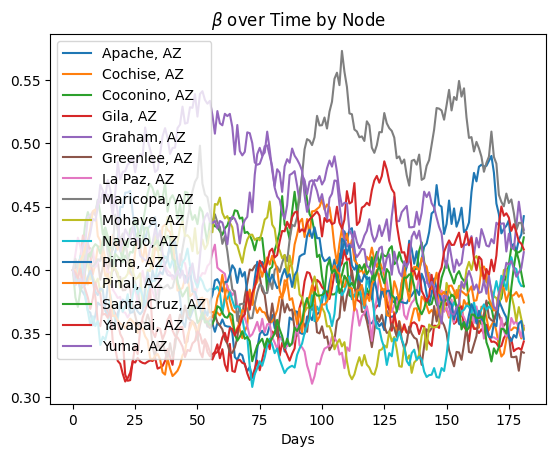

In [4]:
'''Generate a random time dependent beta'''
log_beta_damping = 1/35 * np.ones(scope.nodes)
log_beta_mean = np.log(0.4) * np.ones(scope.nodes)
log_beta_standard_deviation = 0.1 * np.ones(scope.nodes)
initial_log_beta = np.log(0.4) * np.ones(scope.nodes)

delta_t = 1. 

A = np.exp(-log_beta_damping * delta_t)
M = log_beta_mean * (np.exp(-log_beta_damping * delta_t) - 1)
C = log_beta_standard_deviation * np.sqrt(1-np.exp(-2*log_beta_damping * delta_t))

log_beta = np.zeros((scope.nodes,sim_time_frame.duration_days,))
log_beta[:,0] = initial_log_beta

for day in range(1,sim_time_frame.duration_days): 
    log_beta[:,day] = A * log_beta[:,day-1] - M + C * my_rng.normal(size = (scope.nodes,))

beta = np.exp(log_beta)

plt.title('$\\beta$ over Time by Node')
plt.xlabel('Days')
for node in range(scope.nodes): 
    plt.plot(beta[node,:],label = f"{scope.labels[node]}")
plt.legend()
plt.show()

In [5]:
rume = SingleStrataRUME.build(
    ipm=sim_ipm,
    mm=sim_movement_model,
    scope= scope,
    init=init.IndexedLocations(selection=np.arange(scope.nodes),seed_size = 1000),
    time_frame=sim_time_frame,
    params={
        "beta": beta.T,
        "gamma":0.1,
        "xi":1/90,
        "phi":10,
        "hospitalization_prob":0.05,
        "hospitalization_duration":5,
        "centroid": us_tiger.InternalPoint(),
        "population": acs5.Population(),
        "label":us_tiger.Name()
    },
)

Loading gpm:all::mm::population (epymorph.adrio.acs5.Population):
  |####################| 100%  (0.558s)
Running simulation (BasicSimulator):
• 2015-01-01 to 2015-07-01 (182 days)
• 15 geo nodes
  |####################| 100%                     
Runtime: 0.706s


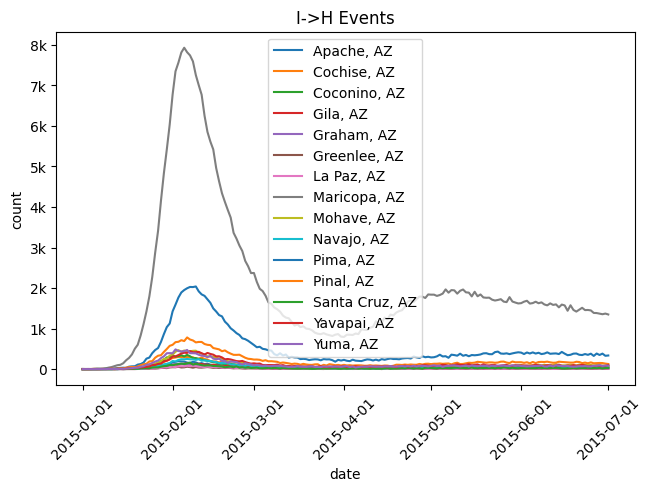

In [6]:
sim = BasicSimulator(rume)

with sim_messaging():
    out = sim.run(
        rng_factory=lambda : my_rng
    )

out.plot.line(
    geo=rume.scope.select.all(),
    time=rume.time_frame.select.all().group('day').agg(),
    quantity=rume.ipm.select.events("I->H"),
    title="I->H Events",
    label_format="{n}",
    legend = "on"
)

In [7]:
from epymorph.adrio import csv
from epymorph.tools.data import munge

cases_df = munge(
    out,
    quantity=rume.ipm.select.events("I->H"),
    time=rume.time_frame.select.all().group("day").agg(),
    geo=rume.scope.select.all(),
)

cases_df.columns = ['date','geoid','value']

cases_df.to_csv('./synthetic_data_comp.csv',index=False)

csvadrio = csv.CSVFileAxN(
    file_path='./synthetic_data_comp.csv',
    dtype=np.int64,
    key_col=1,
    key_type="geoid",
    time_col=0,
    data_col=2,
    skiprows=1
)

In [8]:
my_observations = Observations(
    source=csvadrio,
    model_link=ModelLink(
        geo=rume.scope.select.all(),
        time=rume.time_frame.select.all().group("day").agg(),
        quantity=rume.ipm.select.events("I->H"),
    ),
    likelihood=Poisson()
)

my_unknown_params = {
    "log_beta": UnknownParam(
        prior=GaussianPrior(
            mean=log_beta_mean,
            standard_deviation=log_beta_standard_deviation,
        ),
        dynamics=OrnsteinUhlenbeck(
            damping=log_beta_damping,
            mean=log_beta_mean,
            standard_deviation=log_beta_standard_deviation,
        ),
    )
}

In [9]:
num_realizations = 20

inf_rume = SingleStrataRUME.build(
    ipm=sim_ipm,
    mm=sim_movement_model,
    scope=scope,
    init=RandomLocationsAndRandomSeed(scope.nodes,50_000),
    time_frame=sim_time_frame,
    params={
        "beta": ExponentialTransform("log_beta"),
        "gamma":0.1,
        "xi":1/90,
        "hospitalization_prob":0.05,
        "hospitalization_duration":5,
        "centroid": us_tiger.InternalPoint(),
        "population": acs5.Population(),
        "label":us_tiger.Name()
    },
)

particle_filter_simulator = ParticleFilterSimulator(
    config=PipelineConfig.from_rume(
        inf_rume, num_realizations, unknown_params=my_unknown_params
    ),
    observations=my_observations,
)

In [10]:
particle_filter_output = particle_filter_simulator.run(rng=my_rng)

Observation: 0, Label: 2015-01-01, Time Frame: 2015-01-01 (1D)
Observation: 1, Label: 2015-01-02, Time Frame: 2015-01-02 (1D)
Observation: 2, Label: 2015-01-03, Time Frame: 2015-01-03 (1D)
Observation: 3, Label: 2015-01-04, Time Frame: 2015-01-04 (1D)
Observation: 4, Label: 2015-01-05, Time Frame: 2015-01-05 (1D)
Observation: 5, Label: 2015-01-06, Time Frame: 2015-01-06 (1D)
Observation: 6, Label: 2015-01-07, Time Frame: 2015-01-07 (1D)
Observation: 7, Label: 2015-01-08, Time Frame: 2015-01-08 (1D)
Observation: 8, Label: 2015-01-09, Time Frame: 2015-01-09 (1D)
Observation: 9, Label: 2015-01-10, Time Frame: 2015-01-10 (1D)
Observation: 10, Label: 2015-01-11, Time Frame: 2015-01-11 (1D)
Observation: 11, Label: 2015-01-12, Time Frame: 2015-01-12 (1D)
Observation: 12, Label: 2015-01-13, Time Frame: 2015-01-13 (1D)
Observation: 13, Label: 2015-01-14, Time Frame: 2015-01-14 (1D)
Observation: 14, Label: 2015-01-15, Time Frame: 2015-01-15 (1D)
Observation: 15, Label: 2015-01-16, Time Frame: 20

In [11]:
realization = particle_filter_output.select.all().agg('mean','std','quantiles')
time = rume.time_frame.select.all().group("day").agg('sum')
geo = rume.scope.select.all()
quantity = rume.ipm.select.events('I->H','S->I')

output_df = munge_pipeline_output(particle_filter_output,
                      realization,
                      geo,
                      time,
                      quantity
                      )

output_df

time    geo    S → I                                        \
                           mean         std quantile_0.0 quantile_2.5   
0    2015-01-01  04001   140.95  146.857064          2.0        2.950   
1    2015-01-01  04003   283.80  368.618987          6.0        8.375   
2    2015-01-01  04005   389.95  458.154361         15.0       17.850   
3    2015-01-01  04007   134.30  111.568766         19.0       20.425   
4    2015-01-01  04009   113.05  125.290599         10.0       12.850   
...         ...    ...      ...         ...          ...          ...   
2725 2015-07-01  04019  7295.60  434.068076       6725.0     6745.425   
2726 2015-07-01  04021  2793.90  225.199070       2424.0     2432.075   
2727 2015-07-01  04023   464.05   27.066147        406.0      417.400   
2728 2015-07-01  04025  1536.10  191.579556       1271.0     1285.250   
2729 2015-07-01  04027  1665.00  150.147997       1301.0     1362.750   

                                                            ...         I → H  \
     quantile_5.0 quantile_7.5 quantile_10.0 quantile_12.5  ... quantile_77.5   
0            3.90        8.250          13.0        14.000  ...         2.725   
1           10.75       11.850          12.8        14.125  ...         3.725   
2           20.70       25.675          30.9        32.750  ...         8.725   
3           21.85       25.400          29.2        31.500  ...         3.000   
4           15.70       16.425          16.9        17.375  ...         2.725   
...           ...          ...           ...           ...  ...           ...   
2725      6765.85     6771.825        6776.1      6800.250  ...       389.800   
2726      2440.15     2442.275        2443.7      2465.750  ...       158.725   
2727       428.80      430.425         430.9       431.750  ...        25.000   
2728      1299.50     1303.975        1307.3      1327.500  ...        83.000   
2729      1424.50     1442.475        1455.3      1502.250  ...        86.900   

                                                                            \
     quantile_80.0 quantile_82.5 quantile_85.0 quantile_87.5 quantile_90.0   
0              3.0         3.000          3.00         3.000           3.1   
1              4.8         6.700          8.15         8.625           9.2   
2              9.4        10.350         11.15        11.625          12.0   
3              3.0         3.000          3.15         3.625           4.0   
4              3.4         4.350          5.15         5.625           6.0   
...            ...           ...           ...           ...           ...   
2725         392.6       394.025        395.45       396.875         398.2   
2726         159.0       159.000        159.00       159.000         159.4   
2727          25.2        25.675         26.15        26.625          27.1   
2728          83.4        84.350         85.30        86.250          87.1   
2729          88.4        89.350         90.00        90.000          90.2   

                                                               
     quantile_92.5 quantile_95.0 quantile_97.5 quantile_100.0  
0            3.575          4.20         6.100            8.0  
1           10.150         11.20        13.100           15.0  
2           12.000         12.70        19.350           26.0  
3            4.000          4.15         5.575            7.0  
4            6.000          6.05         6.525            7.0  
...            ...           ...           ...            ...  
2725       399.150        400.50       405.250          410.0  
2726       161.300        163.15       164.575          166.0  
2727        27.575         28.00        28.000           28.0  
2728        87.575         88.60        94.300          100.0  
2729        91.150         92.15        93.575           95.0  

[2730 rows x 88 columns]

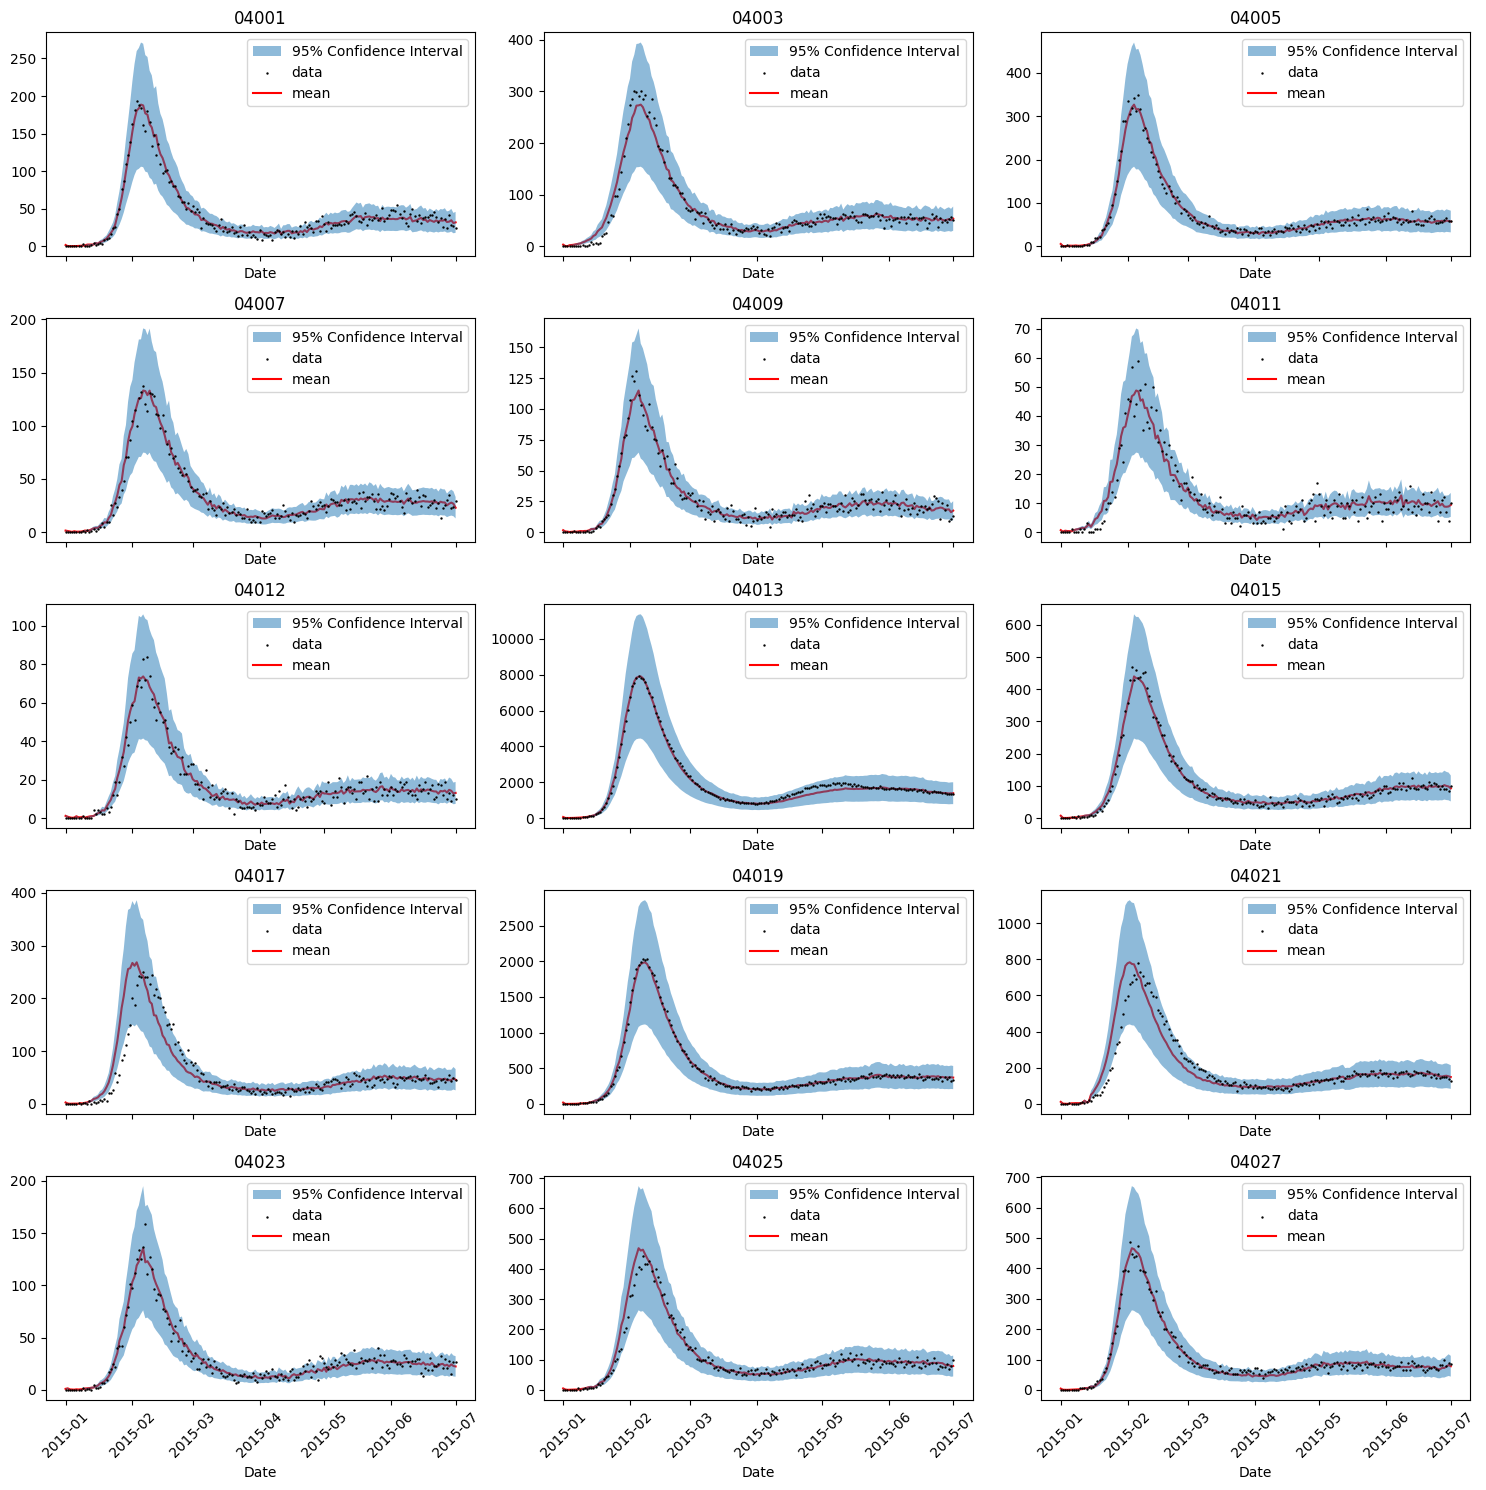

In [12]:
import math

num_nodes = inf_rume.scope.nodes
labels = inf_rume.scope.labels


cols = 3 
rows = math.ceil(num_nodes / cols)

fig, axes = plt.subplots(
    rows,
    cols,
    figsize=(cols * 5, rows * 3),
    sharex = True
)

axes = axes.flatten()
i = 0
for index, ((geo, gdf),(_,cdf)) in enumerate(zip(output_df.groupby("geo", sort=False),cases_df.groupby("geoid", sort = False))):

    i = index
    CI = 1.96 * gdf["I → H"]["mean"]/np.sqrt(num_realizations)
    axes[i].set_title(f'{str(geo)}')
    axes[i].fill_between(gdf["time"],gdf["I → H"]["mean"] - CI, gdf["I → H"]["mean"] + CI,label = '95% Confidence Interval',alpha = 0.5)
    axes[i].scatter(cdf["date"],cdf["value"],color = 'black',s = 0.5,label = 'data')
    axes[i].plot(gdf["time"], gdf["I → H"]["mean"], label='mean',color = 'red',zorder = -1)
    axes[i].tick_params(axis = 'x',labelrotation = 45)
    axes[i].set_xlabel('Date')
    axes[i].legend()

for j in range(i+1,rows * cols): 
    fig.delaxes(axes[j])

fig.tight_layout()


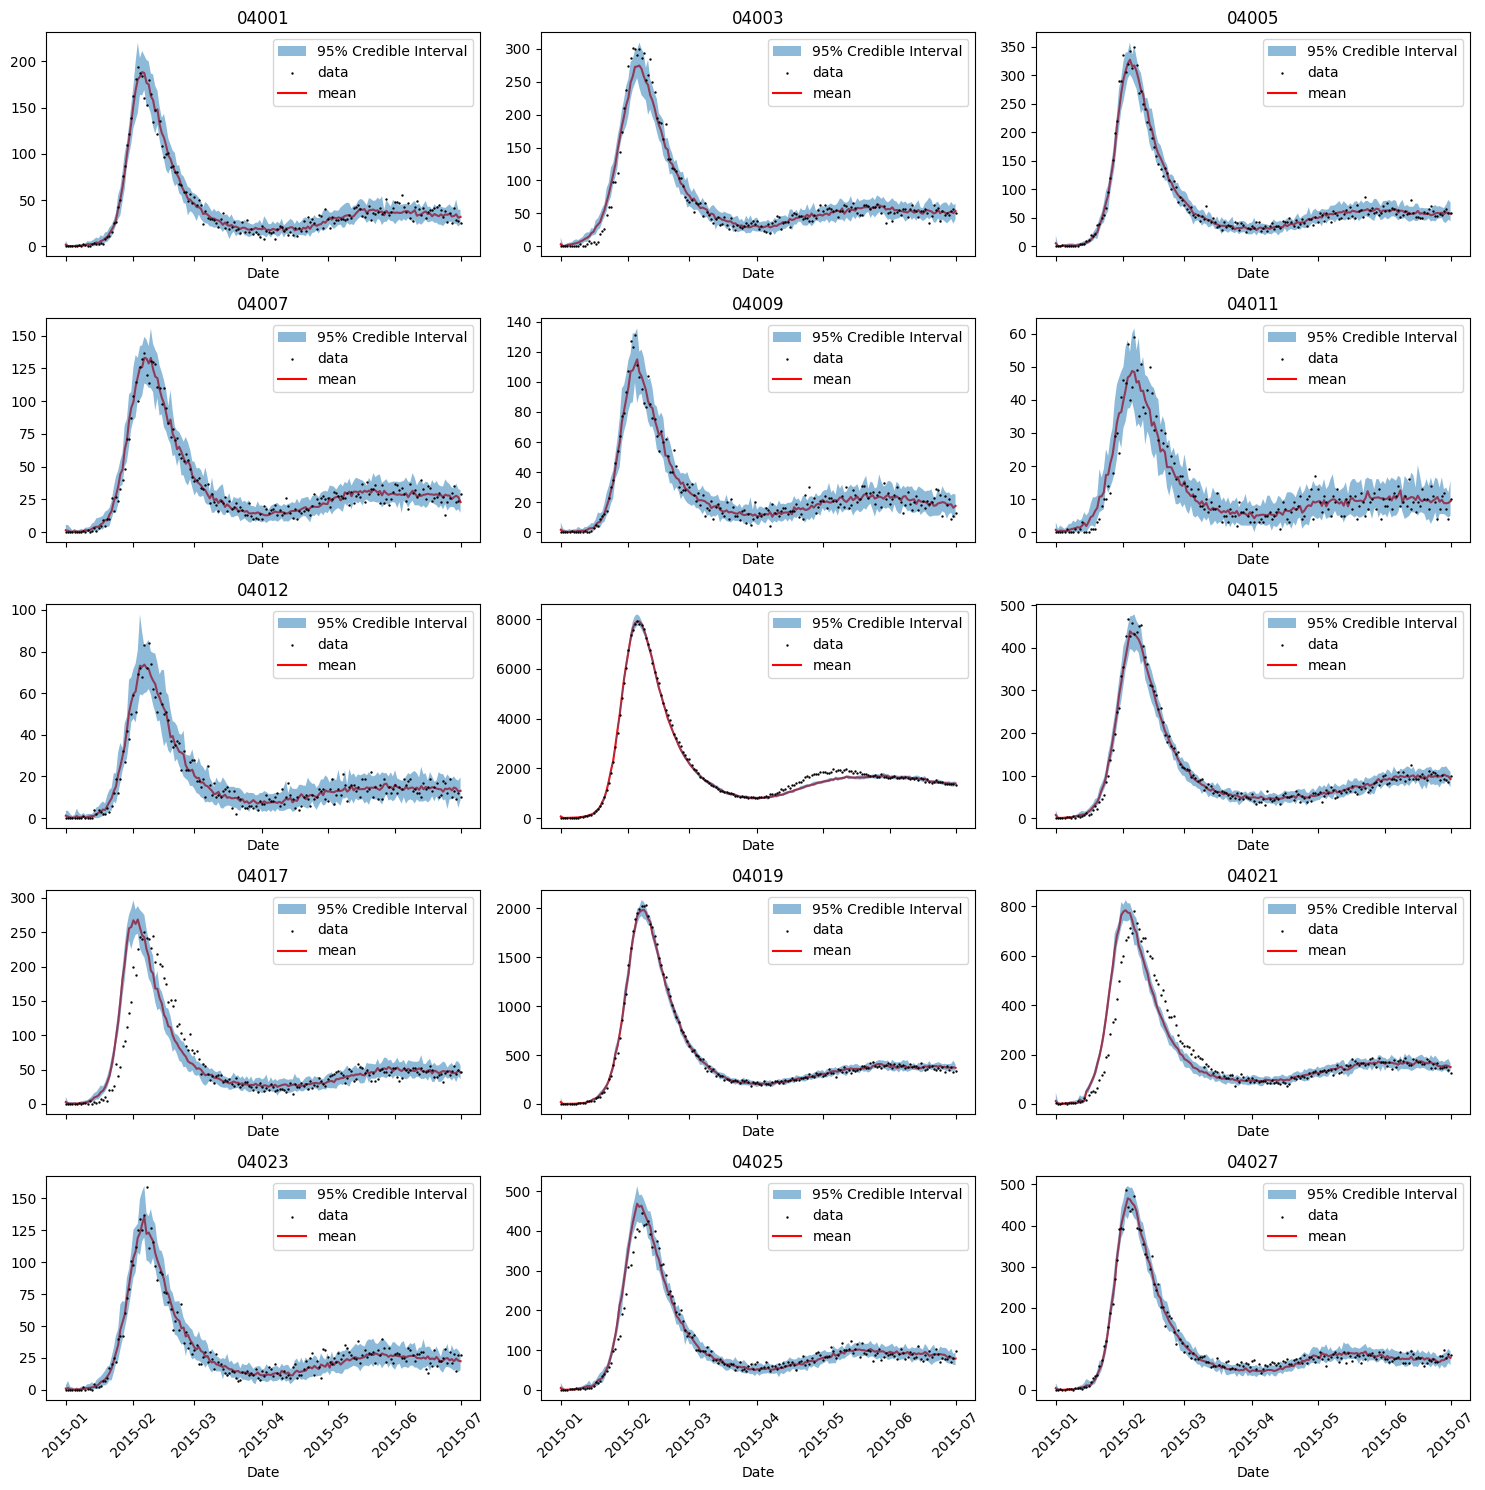

In [13]:
num_nodes = inf_rume.scope.nodes
labels = inf_rume.scope.labels


cols = 3 
rows = math.ceil(num_nodes / cols)

fig, axes = plt.subplots(
    rows,
    cols,
    figsize=(cols * 5, rows * 3),
    sharex = True
)

axes = axes.flatten()
i = 0
for index, ((geo, gdf),(_,cdf)) in enumerate(zip(output_df.groupby("geo", sort=False),cases_df.groupby("geoid", sort = False))):

    i = index
    axes[i].set_title(f'{str(geo)}')
    axes[i].fill_between(gdf["time"],gdf["I → H"]["quantile_2.5"], gdf["I → H"]["quantile_97.5"],label = '95% Credible Interval',alpha = 0.5)
    axes[i].scatter(cdf["date"],cdf["value"],color = 'black',s = 0.5,label = 'data')
    axes[i].plot(gdf["time"], gdf["I → H"]["mean"], label='mean',color = 'red',zorder = -1)
    axes[i].tick_params(axis = 'x',labelrotation = 45)
    axes[i].set_xlabel('Date')
    axes[i].legend()

for j in range(i+1,rows * cols): 
    fig.delaxes(axes[j])

fig.tight_layout()
